Load required modules and libraries.

In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.colors as mcolors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing import image
from keras import utils
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

# Load from functions.py
from functions import load_data, make_predictions, create_mixup_images, find_boundary_points

Global Parameters

In [2]:
MUBA_ITERS = 3

Get and sort testing data

Classes are ['no' 'yes']
[array([1, 0], dtype=uint8), array([1, 0], dtype=uint8), array([0, 1], dtype=uint8), array([1, 0], dtype=uint8), array([0, 1], dtype=uint8)]


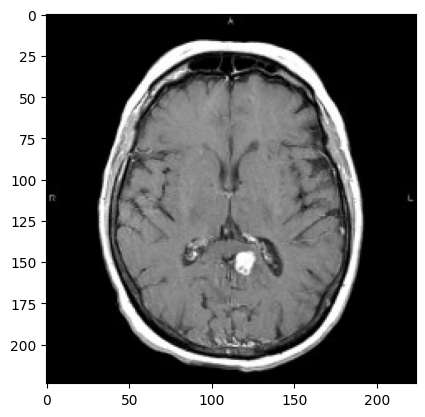

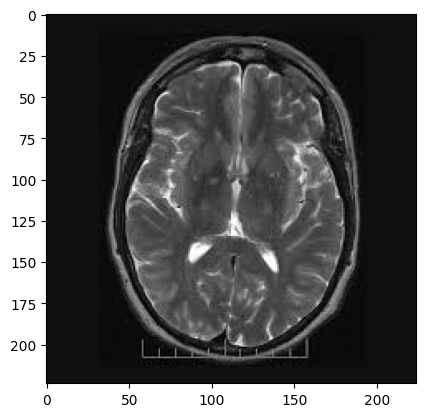

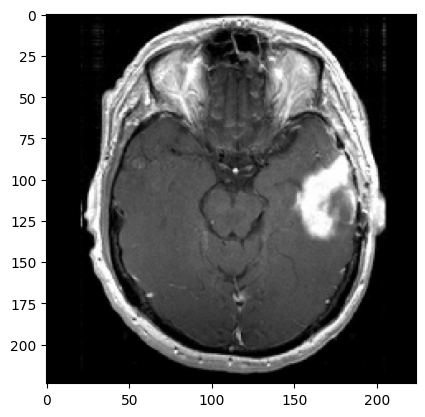

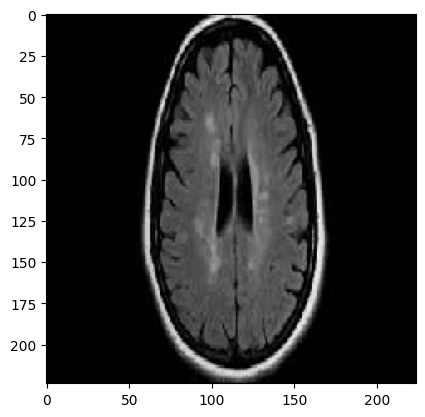

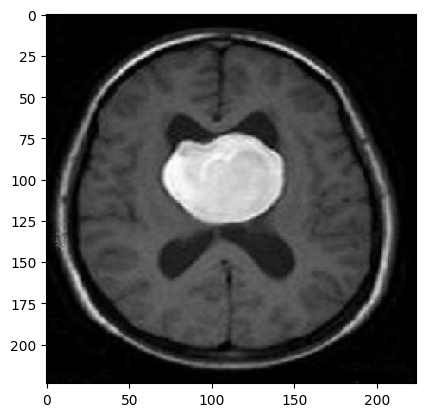

In [35]:
files, labels, images = load_data()   

Load the full classifier, and classifier with final hidden layer activations

In [5]:
model_A = keras.models.load_model("97%.h5")

# Load model with final hidden layer activations
temp_model = tf.keras.Model(model_A.input,model_A.layers[-2].output)

Test the model on test data

In [6]:
final_layers, predictions, pred_array = make_predictions(images, model_A, temp_model)


2/2 [==============================] - 5s 544ms/step
[[0.9805642  0.01943577]
 [0.97279614 0.02720386]
 [0.01185666 0.9881434 ]
 [0.9656943  0.03430562]
 [0.00391701 0.996083  ]]
[0, 0, 1, 0, 1]


In [7]:
initial_df = pd.DataFrame()
initial_df["class"] = [label[1] for label in labels] # 0 if no tumour, 1 if yes tumour # 0 if no tumour, 1 if there is a tumour
initial_df["image_index"] = [i for i in range(len(images))]
initial_df["confidence_class_0"] = [alpha[0] for alpha in predictions]
initial_df["confidence_class_1"] = [alpha[1] for alpha in predictions]

In [8]:
class_zero_df = initial_df[initial_df["class"] == 0] # no tumour
class_one_df = initial_df[initial_df["class"] == 1]
class_one_length = len(class_one_df)
class_zero_length = len(class_zero_df)

Create mixup data

In [10]:
muba_df = create_mixup_images(class_zero_df,class_one_df,images,MUBA_ITERS)

Make predictions on mixup data.

In [12]:
muba_final_layers, muba_prediction, muba_prediction_proper = make_predictions(muba_df["mixup_image"], model_A, temp_model)

34/34 [==============================] - 77s 2s/step
[[0.02990339 0.97009665]
 [0.29293236 0.7070676 ]
 [0.9464926  0.0535074 ]
 [0.01104076 0.9889592 ]
 [0.38649645 0.6135035 ]]
[1, 1, 0, 1, 1]


In [16]:
muba_df["argmax_pred"] = muba_prediction_proper # Adds predictions to muba dataframe

Find boundary points and add them to dataframe.

In [18]:
boundary_points_df = find_boundary_points(muba_df, MUBA_ITERS)

Make predictions to the boundary points

In [19]:
boundary_final_layers, boundary_prediction, boundary_prediction_proper = make_predictions(boundary_points_df["mixup_image"], model_A, temp_model)
boundary_points_df["argmax_pred"] = boundary_prediction_proper

10/10 [==============================] - 21s 2s/step
[[0.67090183 0.3290981 ]
 [0.531397   0.46860304]
 [0.53687435 0.46312562]
 [0.7858829  0.2141171 ]
 [0.47802168 0.5219783 ]]
[0, 0, 0, 0, 1]


Join the mixup data and test data together, so that t-SNE can be applied to all data at once.

In [20]:
muba_df = pd.concat([muba_df,boundary_points_df],axis=0,ignore_index=True)

In [21]:
for image,label,pred in zip(images,labels,pred_array):
    row = pd.DataFrame([({ "alpha_class_0": None, # row 0 is multiplied by lam
                    "alpha_class_1": None,
                    "image_0": None,
                    "image_1":None,
                    "mixup_image": image,
                    "type":"orig",
                    "label":label,
                    "argmax_pred":pred,
                    })])
    muba_df = pd.concat([muba_df, row],axis=0, ignore_index=True)

In [22]:
all_images = muba_df["mixup_image"]
all_final_layers = np.concatenate([muba_final_layers,boundary_final_layers, final_layers])

Find projections

In [23]:
muba_projections = TSNE(2,random_state=1).fit_transform(all_final_layers ) # 1, 

In [24]:
muba_df["projection_x"] = [x[0] for x in muba_projections]
muba_df["projection_y"] = [x[1] for x in muba_projections]

Filter dataframe

In [25]:
true_images_df = muba_df[muba_df["type"] == "orig"]
mixup_images_df =  muba_df[muba_df["type"] == "mix"]
boundary_images_df = muba_df[muba_df["type"] == "boundary"]

In [26]:
min_alpha = []
for i, row in mixup_images_df.iterrows():
    if row["alpha_class_0"] < row["alpha_class_1"]:
        min_alpha.append(row["alpha_class_0"])
    else:
        min_alpha.append(row["alpha_class_1"])

mixup_images_df["min_alpha"] = min_alpha

C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_11116\2393872059.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mixup_images_df["min_alpha"] = min_alpha


In [27]:
true_class_A = true_images_df[true_images_df["label"] == 0]
true_class_B = true_images_df[true_images_df["label"] == 1]

mixup_class_A = mixup_images_df[mixup_images_df["label"] == 0]
mixup_class_B = mixup_images_df[mixup_images_df["label"] == 1]

true_errors = true_images_df[true_images_df["label"] != true_images_df["argmax_pred"]]
mixup_errors = mixup_images_df[mixup_images_df["label"] != mixup_images_df["argmax_pred"]]

error_free_true_class_A = true_class_A[true_class_A["label"] == true_class_A["argmax_pred"]]
error_free_true_class_B = true_class_B[true_class_B["label"] == true_class_B["argmax_pred"]]
error_free_mixup_class_A = mixup_class_A[mixup_class_A["label"] == mixup_class_A["argmax_pred"]]
error_free_mixup_class_B = mixup_class_B[mixup_class_B["label"] == mixup_class_B["argmax_pred"]]


Plot Projections

In [28]:
def plot_projections(colour_by_alpha: bool = True,
                     include_errors: bool = True,
                     outline_errors: bool = True,
                     show_boundary_points: bool = True,
                     scale_errors: bool = False,
                     colour_boundaries_by_alpha: bool = False
                     ):
    
    a=None
    fig, ax = plt.subplots(figsize=(14, 10))

    # Combine two colour maps
    colors1 = plt.cm.Reds_r(np.linspace(0., 1, 128))
    colors2 = plt.cm.Blues(np.linspace(0, 1, 128))

    # Build a new colormap
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

    # Plot mixup points
    if colour_by_alpha:
        ax.scatter(error_free_mixup_class_A["projection_x"],error_free_mixup_class_A["projection_y"],marker="o",s=10,c = error_free_mixup_class_A["alpha_class_0"],cmap = "Reds",vmin=0.5,vmax=1)
        ax.scatter(error_free_mixup_class_B["projection_x"],error_free_mixup_class_B["projection_y"],marker="o",s=10,c = error_free_mixup_class_B["alpha_class_0"],cmap = "Blues_r", label = "Mix-up",vmin=0,vmax=0.5)

    # Plot mixup errors
    if include_errors:

        if colour_by_alpha:
            ax.scatter(mixup_errors["projection_x"],mixup_errors["projection_y"],marker="o",s = (mixup_errors["min_alpha"]*7)**4 if scale_errors else 20 ,c = mixup_errors["alpha_class_0"],cmap = mymap, edgecolors="black",label="Mix-up Incorrect Prediction",vmin=0,vmax=1)
        elif not colour_by_alpha:
            ax.scatter(mixup_class_A["projection_x"],mixup_class_A["projection_y"],marker="o",s=20,color = "salmon",label="Mix-up Class A")
            ax.scatter(mixup_class_B["projection_x"],mixup_class_B["projection_y"],marker="o",s=20,color = "deepskyblue",label="Mix-up Class B")
            ax.scatter(mixup_errors["projection_x"],mixup_errors["projection_y"],marker="o",s=20,color="None",edgecolors = "black" if outline_errors else None,label="Mix-up Incorrect Prediction")
    
    elif not include_errors:
        if not colour_by_alpha:
            ax.scatter(error_free_mixup_class_A["projection_x"],error_free_mixup_class_A["projection_y"],marker="o",s=10,color = "salmon",label="Mix-up Class A")
            ax.scatter(error_free_mixup_class_B["projection_x"],error_free_mixup_class_B["projection_y"],marker="o",s=10,color = "deepskyblue",label="Mix-up Class B")

    # Plot normal points
    ax.scatter(true_class_A["projection_x"],true_class_A["projection_y"],marker="^",s=50,color="red",label="True Class A")
    ax.scatter(true_class_B["projection_x"],true_class_B["projection_y"],marker="^",s=50,color="blue",label="True Class B")
    ax.scatter(true_errors["projection_x"],true_errors["projection_y"],marker="^",s=50,color="None",edgecolors = "black",label="Incorrect Prediction",)

    if show_boundary_points:
        ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"],marker="o",s=20,c="green" if not colour_boundaries_by_alpha else boundary_images_df["alpha_class_0"],cmap = mymap if colour_boundaries_by_alpha else None, vmin = 0, vmax = 1 ,label="Boundary Points", edgecolors = "black" if colour_boundaries_by_alpha else None)
    
    ax.legend()

    ax.set_title("t-SNE Dimension Analysis")

    if colour_by_alpha or colour_boundaries_by_alpha or include_errors:
        a = ax.scatter([0,1],[0,1],s=0,vmin=0,vmax=1,c=[0,1],cmap=mymap)
        plt.colorbar(a,label = "Class A Alpha Value")
    

    plt.show()

C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_11116\3794364566.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(boundary_images_df["projection_x"],boundary_images_df["projection_y"],marker="o",s=20,c="green" if not colour_boundaries_by_alpha else boundary_images_df["alpha_class_0"],cmap = mymap if colour_boundaries_by_alpha else None, vmin = 0, vmax = 1 ,label="Boundary Points", edgecolors = "black" if colour_boundaries_by_alpha else None)


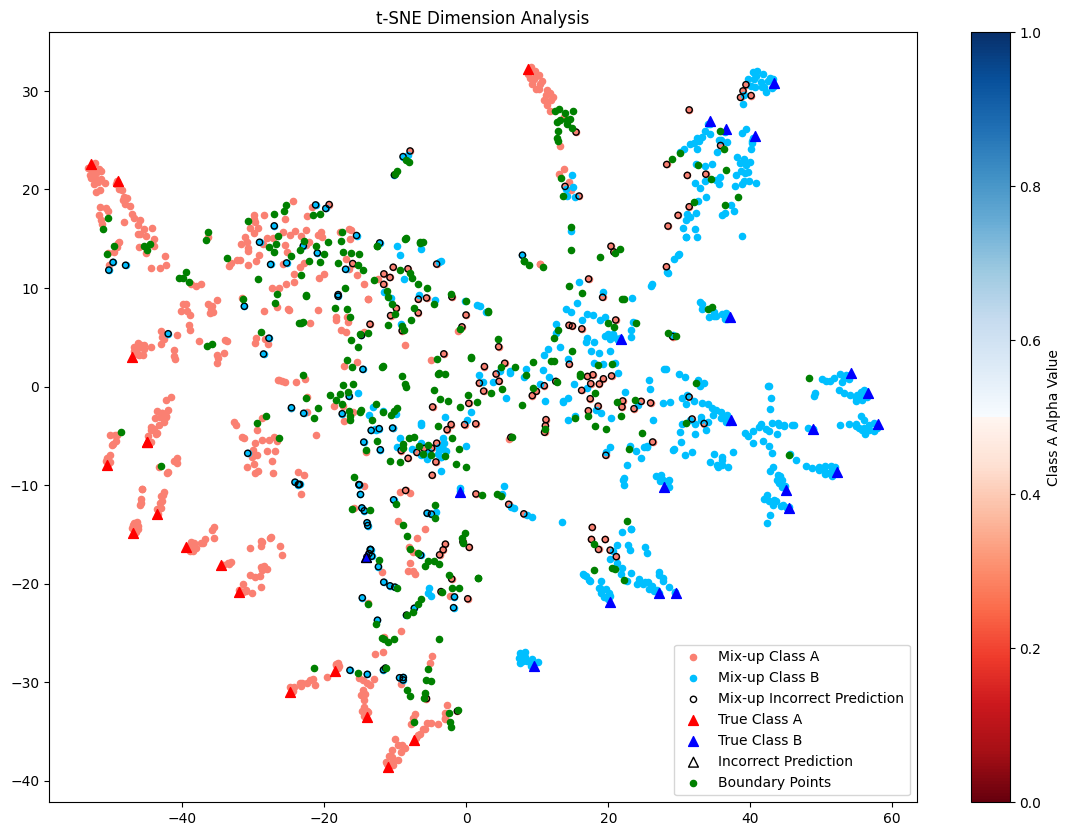

In [29]:
"""(colour_by_alpha: bool = True,
        include_errors: bool = True,
        outline_errors: bool = True,
        show_boundary_points: bool = True,
        scale_errors: bool = False,
        colour_boundaries_by_alpha: bool = False
                     ):
    """
# plot_projections(True,True,False,True,False)
# plot_projections(False,True,False,True,False)
# plot_projections(True,True,True,True,False)
# plot_projections(False,False,False,False,False)
plot_projections(False,True,True,True,False,False)

Text(0.5, 1.0, 'Test Data')

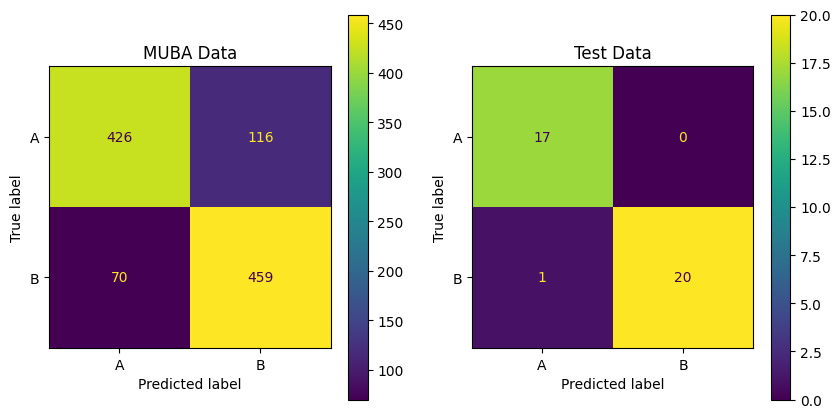

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

fig, axs = plt.subplots(1,2, figsize = (10,5))
cm_muba = confusion_matrix([x for x in mixup_images_df["label"]],[y for y in mixup_images_df["argmax_pred"]])
cm_test = confusion_matrix([x for x in true_images_df["label"]],[y for y in true_images_df["argmax_pred"]])

cm_muba_display = ConfusionMatrixDisplay(confusion_matrix = cm_muba, display_labels=["A","B"])
cm_test_display = ConfusionMatrixDisplay(confusion_matrix = cm_test, display_labels=["A","B"])

cm_muba_display.plot(ax = axs[0])
cm_test_display.plot(ax = axs[1])

axs[0].set_title("MUBA Data")
axs[1].set_title("Test Data")

Text(0.5, 1.0, 'Boundary Distribution Curve')

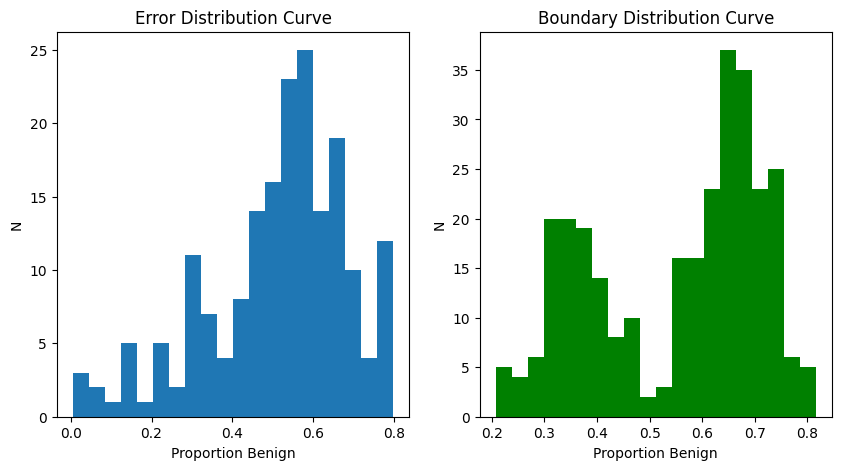

In [34]:
fig, axs = plt.subplots(1,2, figsize = (10,5))

axs[0].hist(mixup_errors["alpha_class_0"],20,)
axs[0].set_ylabel("N")
axs[0].set_xlabel("Proportion Benign")
axs[0].set_title("Error Distribution Curve")

axs[1].hist(boundary_points_df["alpha_class_0"],20,color="green")
axs[1].set_ylabel("N")
axs[1].set_xlabel("Proportion Benign")
axs[1].set_title("Boundary Distribution Curve")